# **Importing Libraries**

In [1]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# **Loading IMDB Dataset**

In [2]:
# Load IMDB dataset
vocab_size = 10000
(train_sequences, train_targets), (test_sequences, test_targets) = imdb.load_data(num_words=vocab_size)

# Set maximum sequence length
sequence_length = 150
train_sequences = pad_sequences(train_sequences, maxlen=sequence_length)
test_sequences = pad_sequences(test_sequences, maxlen=sequence_length)

In [3]:
# Subsets of data for training (100, 500, 1000 samples)
training_sizes = [100, 500, 1000]
train_data_samples = [train_sequences[:size] for size in training_sizes]
train_labels_samples = [train_targets[:size] for size in training_sizes]

# **Loading pretrained GloVe embeddings**


In [4]:
# Load pretrained GloVe embeddings
embedding_index = {}
embedding_dimension = 100
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

In [5]:
# Prepare the GloVe embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dimension))
word_index = imdb.get_word_index()
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# **RNN Model with Random Embedding**

In [6]:
# Build complex RNN model with random embeddings
def build_standard_rnn(input_length):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dimension, input_shape=(input_length,)))
    model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, input_length))  # Specify input shape here
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# **RNN Model with Pre trained GloVe embeddings**

In [7]:
# Build enhanced RNN model with pretrained GloVe embeddings
def build_pretrained_rnn(input_length, embedding_matrix=None):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dimension, input_shape=(input_length,),
                        weights=[embedding_matrix] if embedding_matrix is not None else None,
                        trainable=True))
    model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, input_length))  # Specify input shape here
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# **Plotting Function**

In [8]:
# Plotting function to compare accuracy and loss
def plot_metrics(history, model_name, sample_size):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='teal')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='coral')
    ax[0].set_title(f'{model_name} Accuracy - {sample_size} Samples')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot loss
    ax[1].plot(history.history['loss'], label='Training Loss', color='teal')
    ax[1].plot(history.history['val_loss'], label='Validation Loss', color='coral')
    ax[1].set_title(f'{model_name} Loss - {sample_size} Samples')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# **Model Summary**

In [9]:
model_rnn = build_standard_rnn(sequence_length)
print("Standard RNN Model :")
print(model_rnn.summary())
model_pretrained_rnn = build_pretrained_rnn(sequence_length, embedding_matrix)
print("Pretrained GloVe RNN Model :")
print(model_pretrained_rnn.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Standard RNN Model :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 150, 64)             │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 150, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,070,337 (4.08 MB)

 Trainable params: 1,070,337 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

None
Pretrained GloVe RNN Model :


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 150, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 150, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 150, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 150, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,228,737 (4.69 MB)

 Trainable params: 1,228,737 (4.69 MB)

 Non-trainable params: 0 (0.00 B)

None


# **Model Training**


Training with 100 samples...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5047 - loss: 0.6942 - val_accuracy: 0.5110 - val_loss: 0.6930
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.5620 - loss: 0.6898 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5808 - loss: 0.6845 - val_accuracy: 0.5000 - val_loss: 0.6955
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5832 - loss: 0.6735 - val_accuracy: 0.5000 - val_loss: 0.7001
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - accuracy: 0.5853 - loss: 0.6612 - val_accuracy: 0.5000 - val_loss: 0.7089
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5987 - loss: 0.6458 - val_accuracy: 0.5000 - val_loss: 0.7280
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5165 - loss: 0.6929
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5499 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.7215
Epoch 2/20
4/4 ━━━━━━━━━━

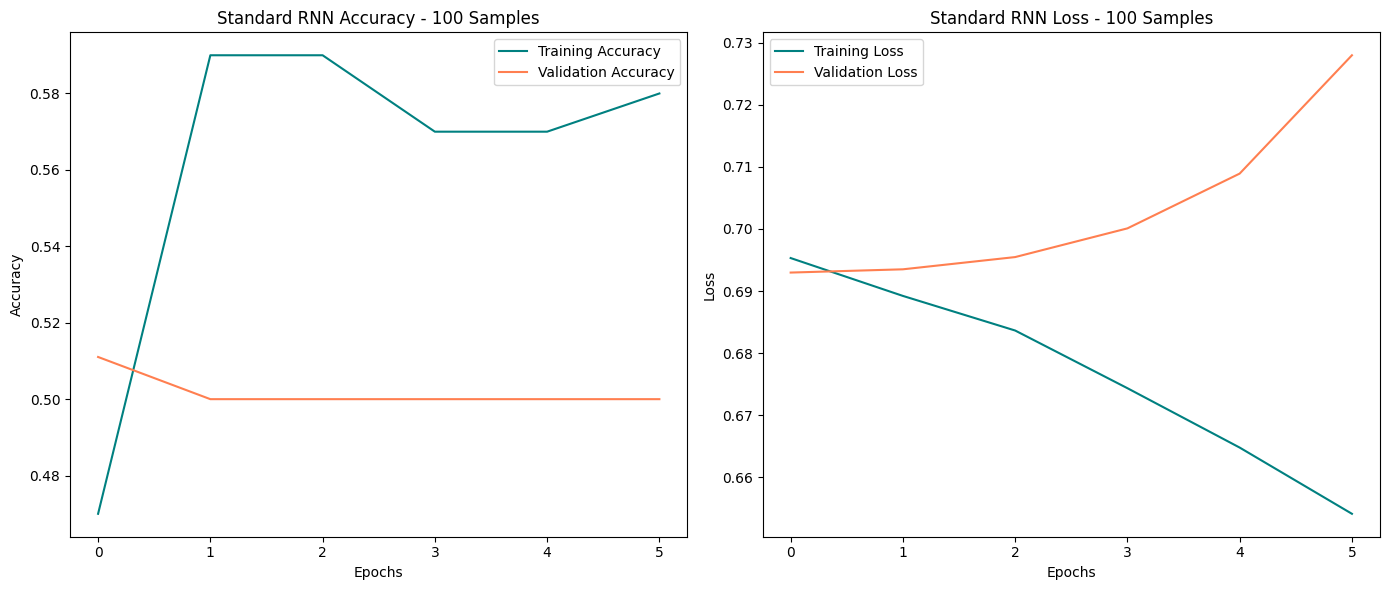

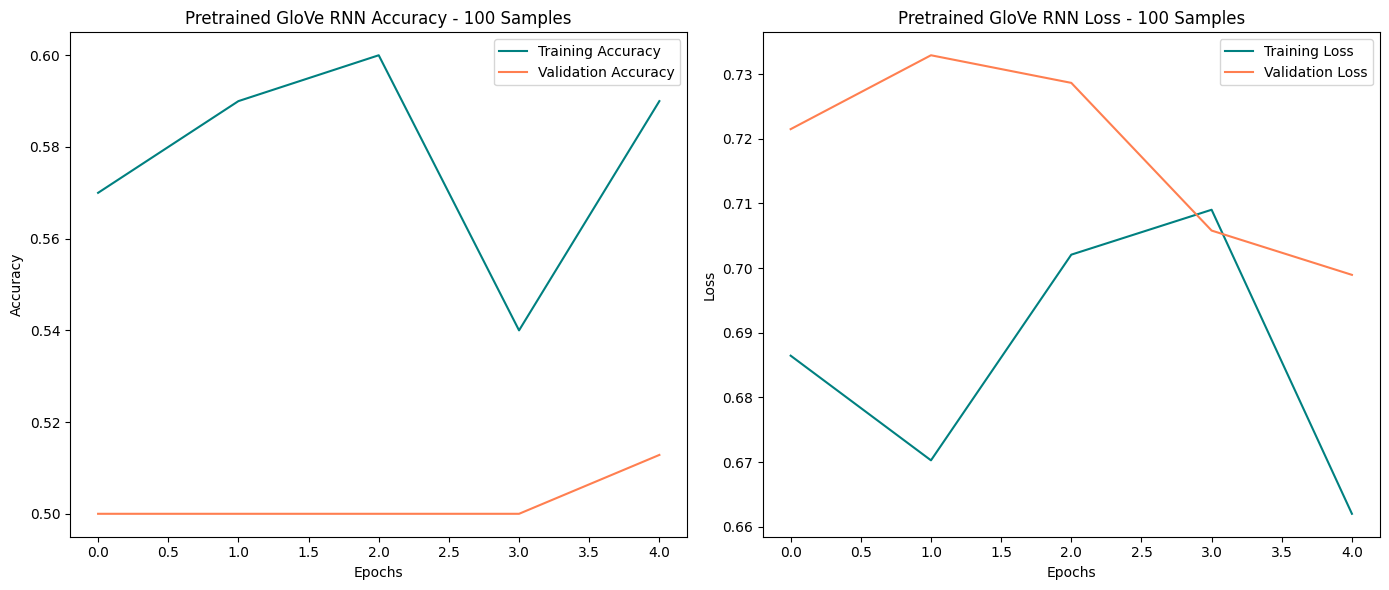


Training with 500 samples...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 763ms/step - accuracy: 0.4803 - loss: 0.6936 - val_accuracy: 0.5130 - val_loss: 0.6928
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 780ms/step - accuracy: 0.5570 - loss: 0.6913 - val_accuracy: 0.5191 - val_loss: 0.6923
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 778ms/step - accuracy: 0.6510 - loss: 0.6829 - val_accuracy: 0.6312 - val_loss: 0.6671
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 699ms/step - accuracy: 0.8803 - loss: 0.5093 - val_accuracy: 0.6764 - val_loss: 0.6363
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9756 - loss: 0.1864 - val_accuracy: 0.6724 - val_loss: 0.8979
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 696ms/step - accuracy: 0.9907 - loss: 0.0710 - val_accuracy: 0.6761 - val_loss: 1.1621
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 774ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 0.6772 - val_loss: 1.4369
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - accuracy: 1.000

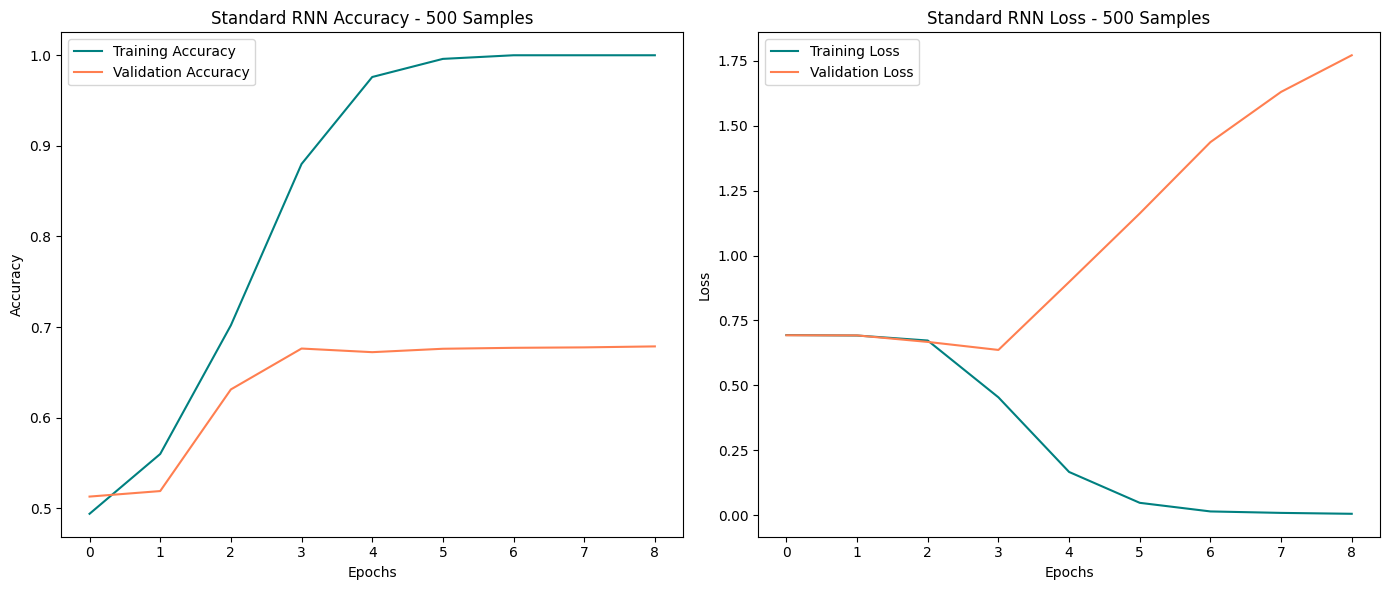

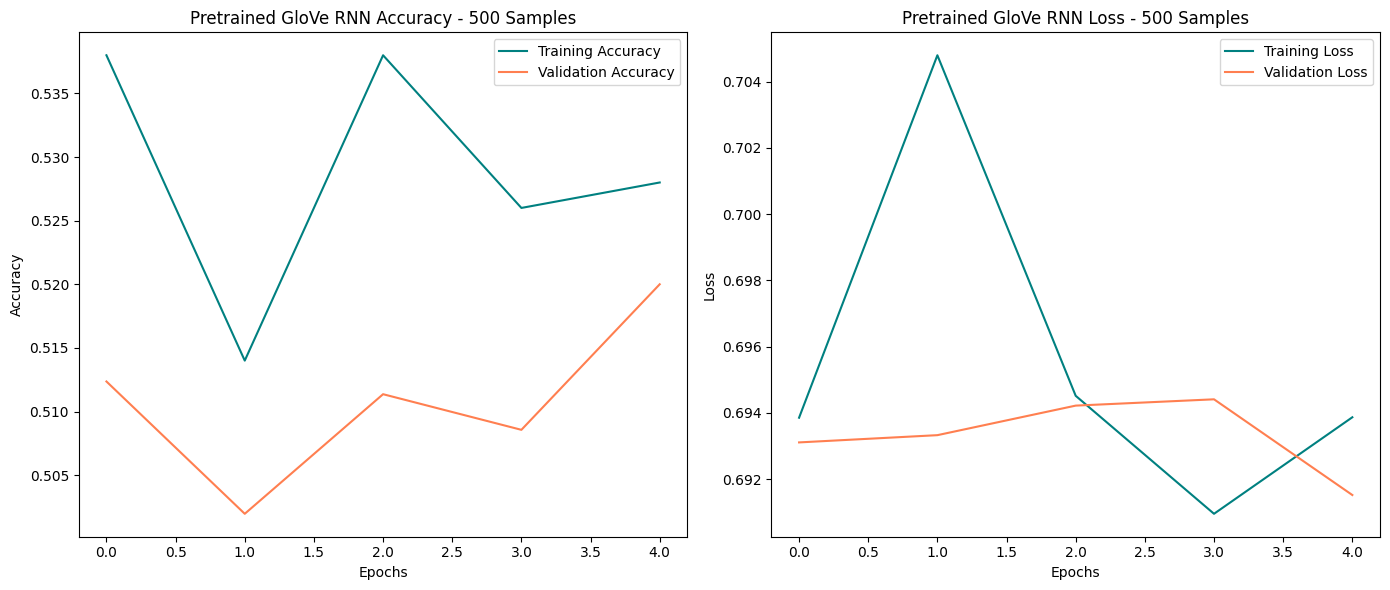


Training with 1000 samples...
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - accuracy: 0.4975 - loss: 0.6929 - val_accuracy: 0.5505 - val_loss: 0.6891
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 403ms/step - accuracy: 0.7226 - loss: 0.6369 - val_accuracy: 0.6566 - val_loss: 0.6073
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.8999 - loss: 0.3141 - val_accuracy: 0.7072 - val_loss: 0.7570
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 401ms/step - accuracy: 0.9784 - loss: 0.0939 - val_accuracy: 0.7224 - val_loss: 1.0543
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9901 - loss: 0.0442 - val_accuracy: 0.7071 - val_loss: 1.1913
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.9982 - loss: 0.0115 - val_accuracy: 0.7205 - val_loss: 1.3715
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.7216 - val_loss: 1.5753
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6520 - lo

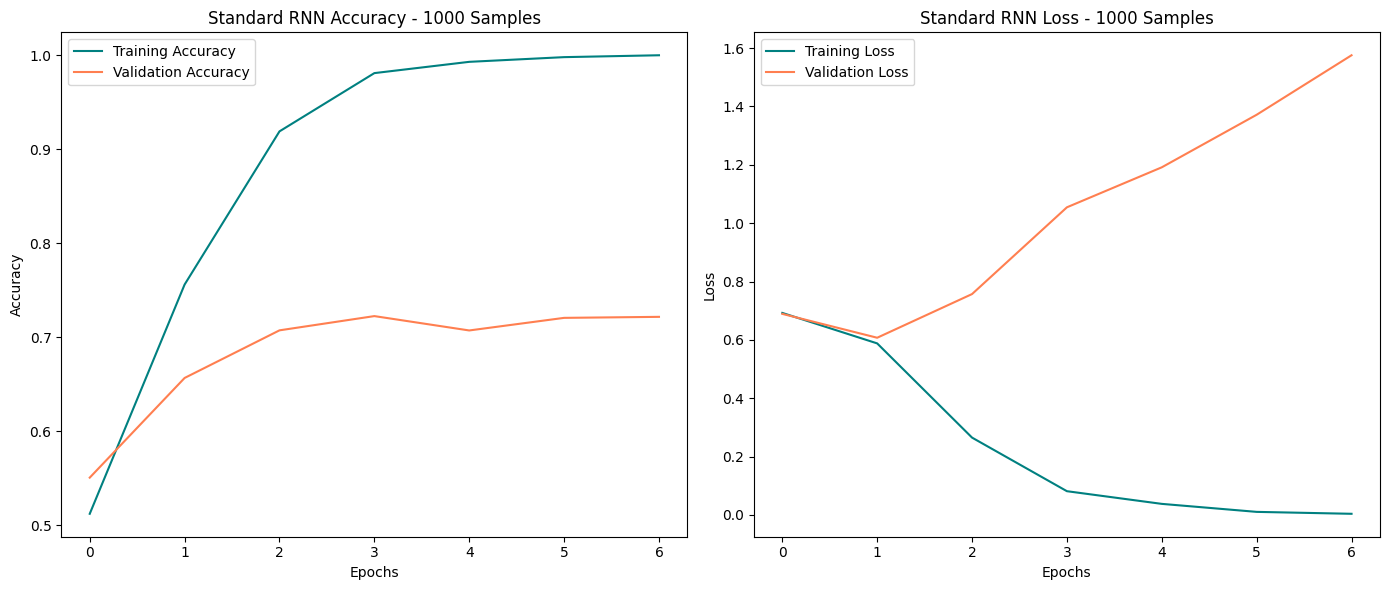

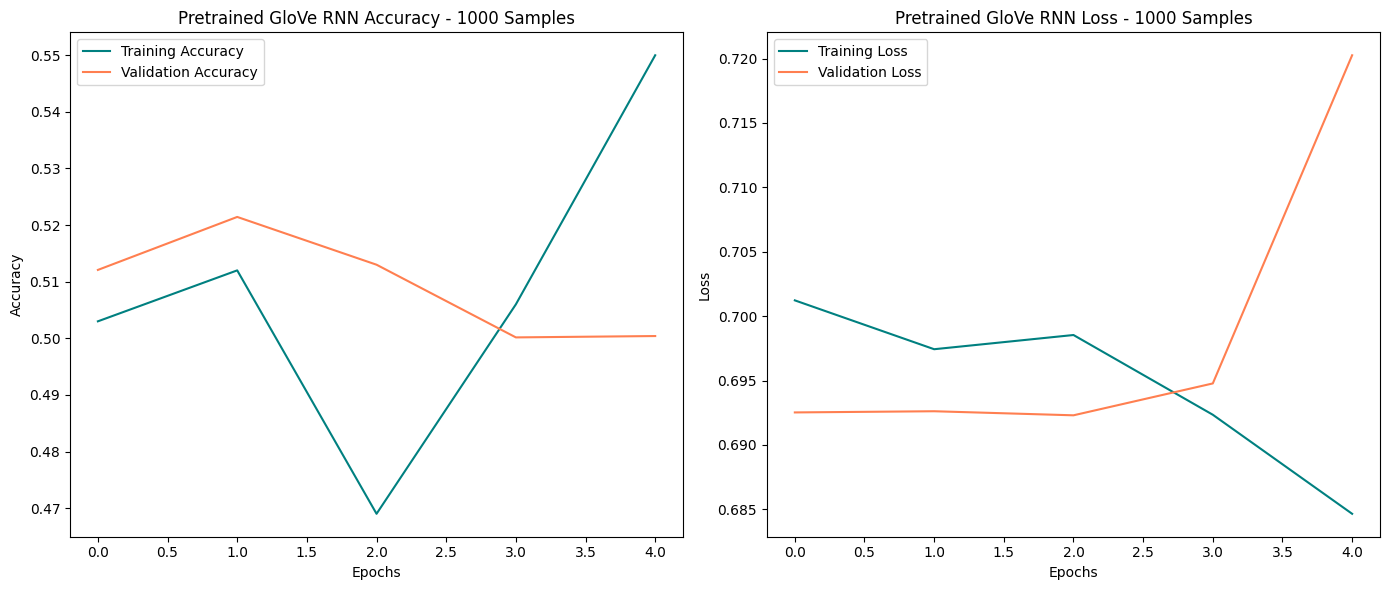

In [10]:
# Train and evaluate models for different sample sizes
results_comparison = []
for size, data, labels in zip(training_sizes, train_data_samples, train_labels_samples):
    print(f"\nTraining with {size} samples...")

    # Standard RNN with random embeddings
    model_rnn = build_standard_rnn(sequence_length)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    rnn_history = model_rnn.fit(data, labels, epochs=20, batch_size=32,
                                validation_data=(test_sequences, test_targets),
                                callbacks=[early_stopping])

    # Evaluate standard RNN
    rnn_loss, rnn_accuracy = model_rnn.evaluate(test_sequences, test_targets)

    # Pretrained GloVe RNN
    model_pretrained_rnn = build_pretrained_rnn(sequence_length, embedding_matrix)
    pretrained_rnn_history = model_pretrained_rnn.fit(data, labels, epochs=20, batch_size=32,
                                                      validation_data=(test_sequences, test_targets),
                                                      callbacks=[early_stopping])

    # Evaluate pretrained GloVe RNN
    pretrained_rnn_loss, pretrained_rnn_accuracy = model_pretrained_rnn.evaluate(test_sequences, test_targets)

    # Store comparison results
    results_comparison.append({
        'Sample Size': size,
        'Standard RNN Accuracy': rnn_accuracy,
        'Pretrained GloVe RNN Accuracy': pretrained_rnn_accuracy,
        'Standard RNN Loss': rnn_loss,
        'Pretrained GloVe RNN Loss': pretrained_rnn_loss
    })

    # Plot metrics for each model
    plot_metrics(rnn_history, 'Standard RNN', size)
    plot_metrics(pretrained_rnn_history, 'Pretrained GloVe RNN', size)


# **Model Comparison**

In [11]:
# Create DataFrame for results and visualize
df_results = pd.DataFrame(results_comparison)
print("\nComparative Results:")
print(df_results)


Comparative Results:
   Sample Size  Standard RNN Accuracy  Pretrained GloVe RNN Accuracy  \
0          100                0.51104                        0.50000   
1          500                0.67636                        0.51236   
2         1000                0.65656                        0.51208   

   Standard RNN Loss  Pretrained GloVe RNN Loss  
0           0.692982                   0.721475  
1           0.636255                   0.693111  
2           0.607266                   0.692524  


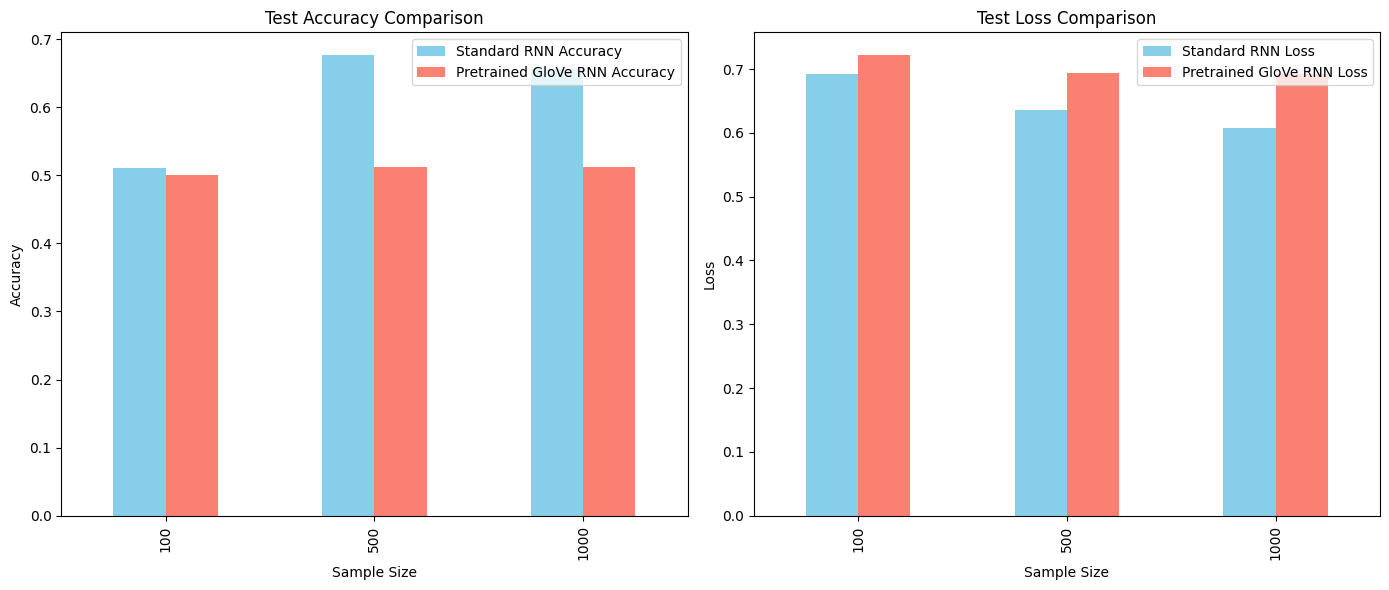

In [12]:
# Plot accuracy and loss comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
df_results.plot(x='Sample Size', y=['Standard RNN Accuracy', 'Pretrained GloVe RNN Accuracy'],
                kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylabel('Accuracy')

# Loss comparison
df_results.plot(x='Sample Size', y=['Standard RNN Loss', 'Pretrained GloVe RNN Loss'],
                kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Test Loss Comparison')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()